In [1]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mellon as ml
import glob


c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(9708, 45)
(8345, 45)


<Figure size 1050x1050 with 0 Axes>

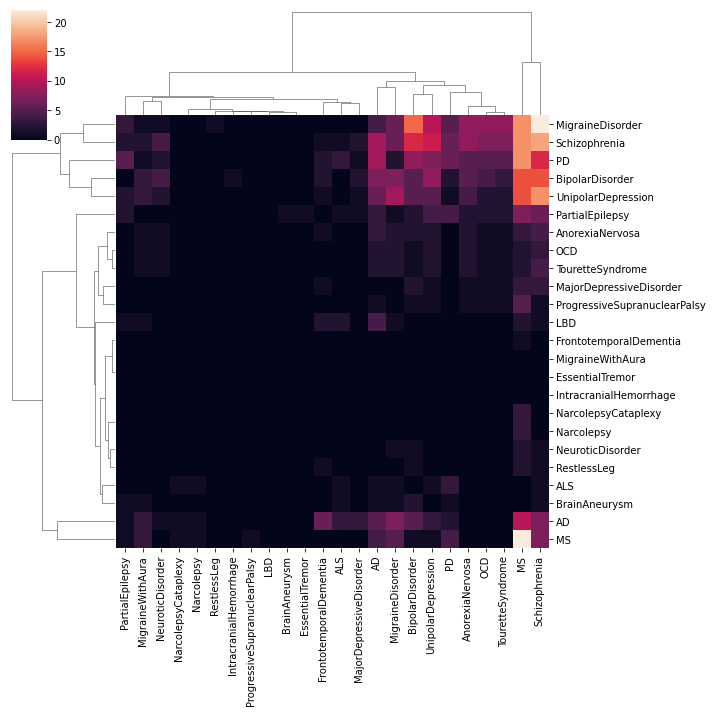

<Figure size 1050x1050 with 0 Axes>

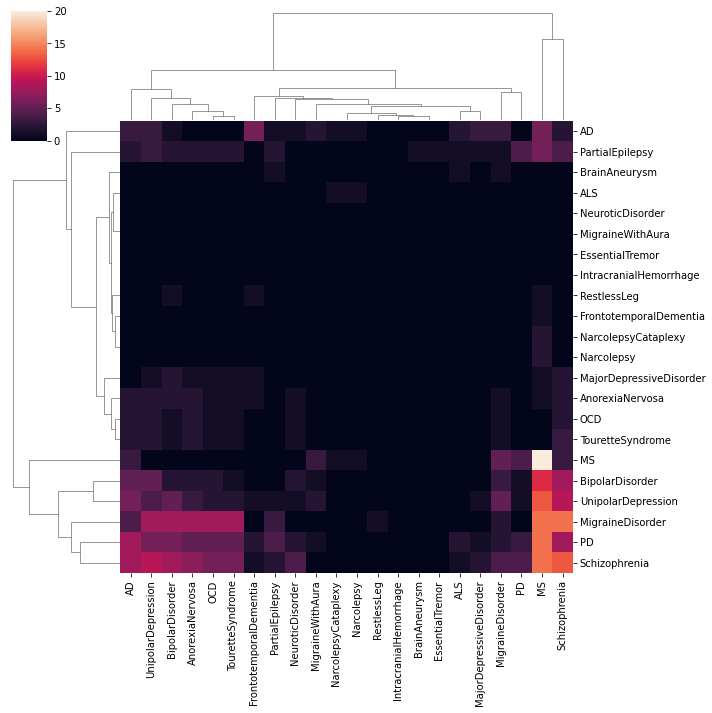

<Figure size 1050x1050 with 0 Axes>

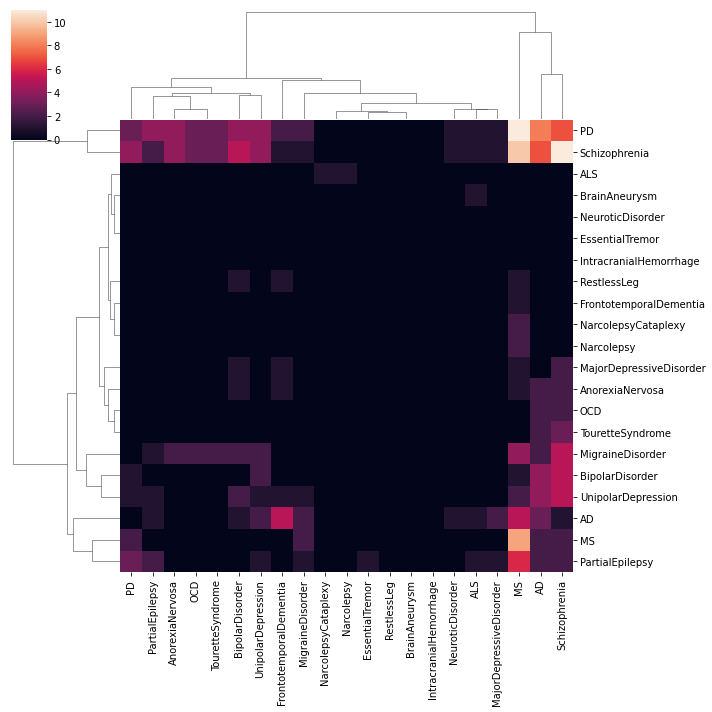

<Figure size 1050x1050 with 0 Axes>

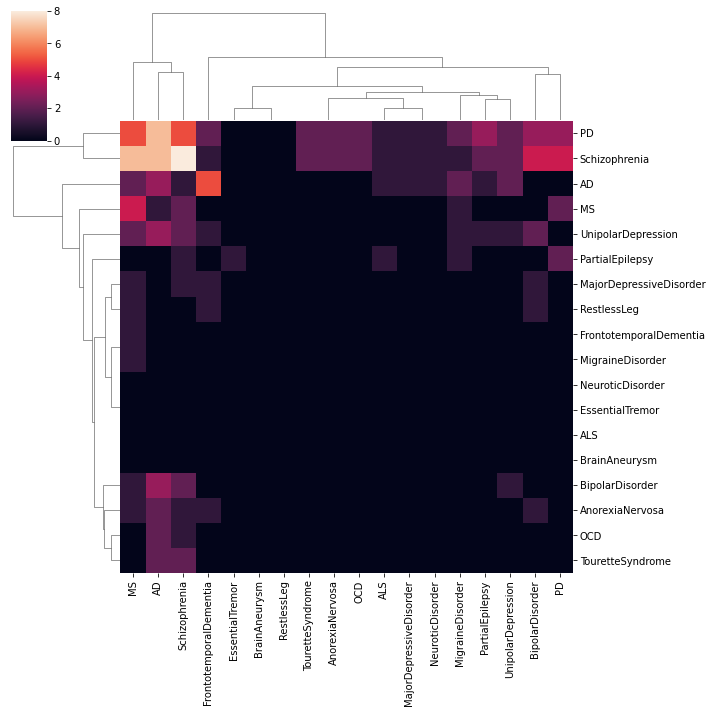

<Figure size 1050x1050 with 0 Axes>

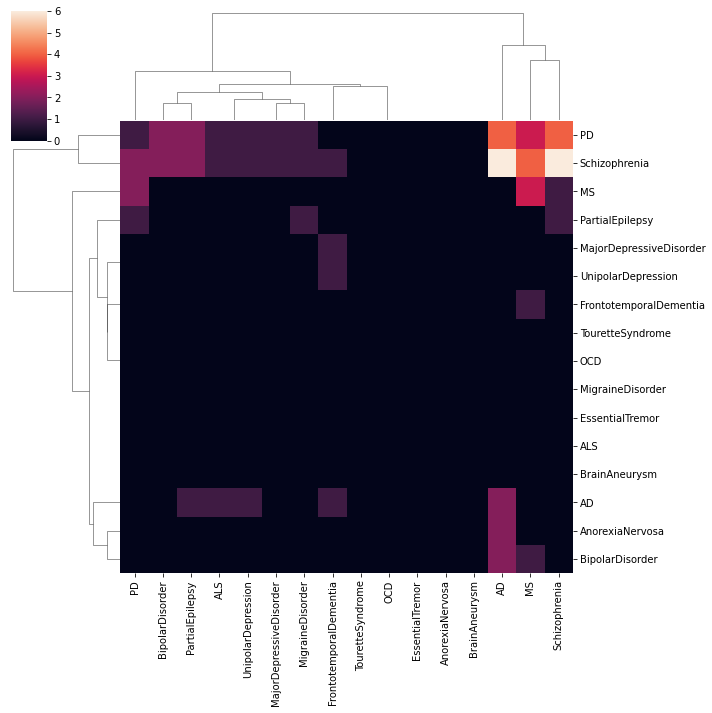

<Figure size 1050x1050 with 0 Axes>

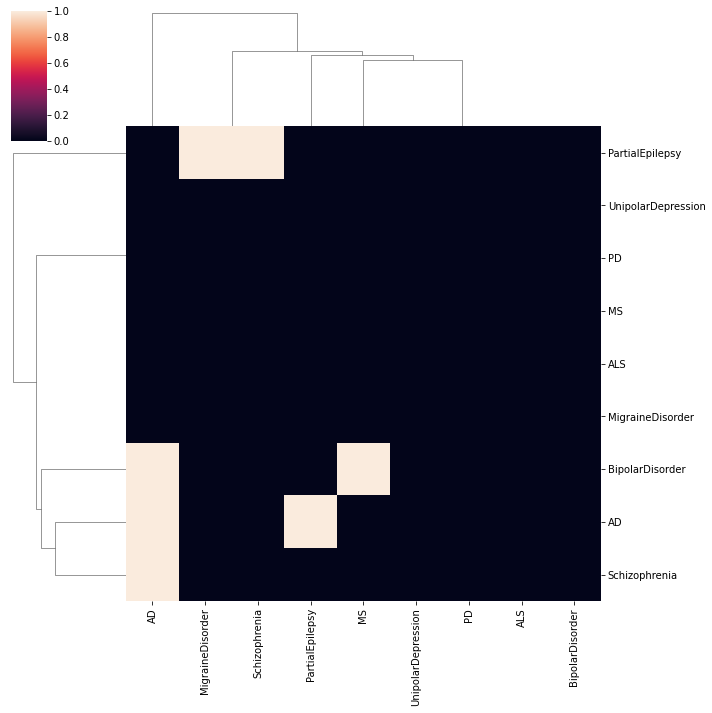

<Figure size 1050x1050 with 0 Axes>

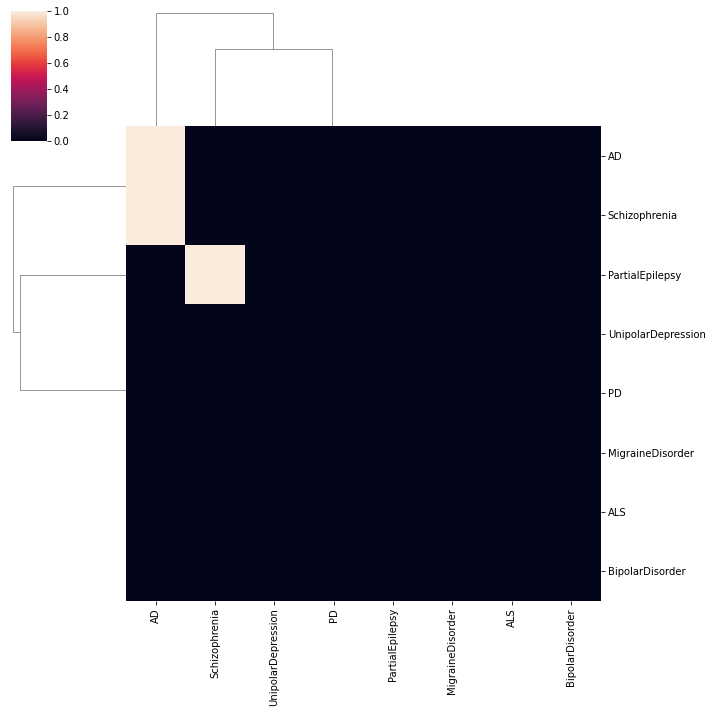

In [2]:
path = glob.glob("processed_data/hot-encoded-diseases_*.csv")

comparison = pd.DataFrame(np.zeros(shape=(7,5)), index = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], columns = ['number of LRs', 'number of diseases', '% ligands', '% receptors', '% genes in major network'])

db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
print(np.shape(db))
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]
print(np.shape(db))

for res in range(0,len(path)):
    tgts_all = pd.read_csv(path[res])
    tgts_all['gene']=tgts_all['genes']
    tgts = tgts_all.drop(columns=['genes']).set_index(['gene'])

    source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)
    LRpairs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) & (db['genesymbol_intercell_target'].isin(list(sum.gene)))]
    LRpairs['source_disease'] = ''
    LRpairs['target_disease'] = ''
    
    for m in range(0,np.shape(LRpairs)[0]):
        subset = tgts.loc[LRpairs.iloc[m]['genesymbol_intercell_source']]!=0
        LRpairs['source_disease'].iloc[m] = ','.join(list(subset[subset==True].index))
        subset = tgts.loc[LRpairs.iloc[m]['genesymbol_intercell_target']]!=0
        LRpairs['target_disease'].iloc[m] = ','.join(list(subset[subset==True].index))
    LRpairs.to_csv('processed_data/05-PD_analysis/05b_PD_LR_overlap_other_diseases/LR_pairs_with_disease_annotation_%s.csv' % path[res].split('_')[2].split('.csv')[0])
    tgts.drop(columns = ['Empty'], inplace = True)
    LR_disease_adjmat = pd.DataFrame(np.zeros(shape = (len(tgts.columns), len(tgts.columns))), index = tgts.columns, columns = tgts.columns)

    for interaction in range(0,np.shape(LRpairs)[0]):
        source_dis_list = LRpairs.iloc[interaction]['source_disease'].split(',')
        target_dis_list = LRpairs.iloc[interaction]['target_disease'].split(',')
        for S in range(0,len(source_dis_list)):
            for T in range(0,len(target_dis_list)):
                LR_disease_adjmat.loc[source_dis_list[S]][target_dis_list[T]] += 1
    LR_disease_adjmat.to_csv('processed_data/05-PD_analysis/05b_PD_LR_overlap_other_diseases/LR_disease_overlap_heatmap_%s.csv' % path[res].split('_')[2].split('.csv')[0])

    plt.figure(figsize=(7,7), dpi = 150)
    sns.clustermap(LR_disease_adjmat)
    plt.savefig('plots/05-PD_analysis/05b_PD_LR_overlap_other_diseases/LR_disease_overlap_clustermap_%s.pdf' % path[res].split('_')[2].split('.csv')[0])
    plt.savefig('plots/05-PD_analysis/05b_PD_LR_overlap_other_diseases/LR_disease_overlap_clustermap_%s.png' % path[res].split('_')[2].split('.csv')[0], dpi = 300, bbox_inches = 'tight')
    plt.show()
